## Steps to process a frame

A video is composed of many frames. Each frame is an image. In order to process an image and detect the lane markings, we perform the following steps:

- Read the frame as an image
- Choose Region of Interest (ROI)
- Choose the threshold for selecting lanes
- Remove noise from the thresholded image by using erosion and dilation
- Perform Canny Edge Detector and HoughTransform
- Using Linear Regression to estimate the lane markings, according to the result of Hough Transform
- Draw the lanes and paint the lane area
- Calculate distance to the middle lane
- Calculate lane width

## Read the frame as an image

To read a frame of the video, we use `cv2.VideoCapture`. It allows us to iterate over the video and read a particular frame at any moment

In [ ]:
# Iterate over a video file and process each frame
import cv2

def process(img):
    # We can edit the image here as you wish, for now, this is the placeholder
    return img

cap = cv2.VideoCapture('./sample/sample2.mp4')
while (True):
    ret, img = cap.read()
    if (ret == False):
        break
    cv2.imshow("img", process(img))
    cv2.waitKey(1)

# Please don't run this or the kernel would die

We can also read the frame from a particular moment

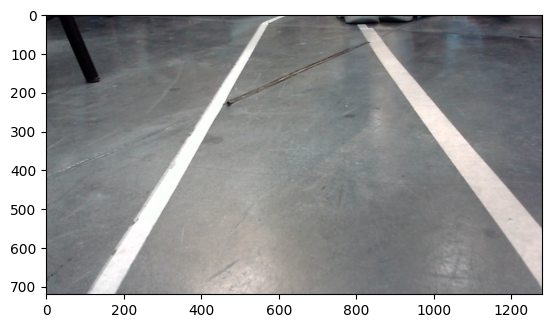

In [24]:
import cv2
import matplotlib.pyplot as plt

def process(img):
    # We can edit the image here as you wish, for now, this is the placeholder
    return img

cap = cv2.VideoCapture('./sample/sample2.mp4')
cap.set(cv2.CAP_PROP_POS_MSEC,1400) # Read the image at 1.4 seconds
ret, img = cap.read()
plt.imshow(process(img))

From now on, we only have to write the function `process(img)`

## Choose the Region of Interest (ROI)

We want to exclude certain parts of the image because including everything may result in lots of noise. We decided to choose the lower half of the image with size 640 x 400

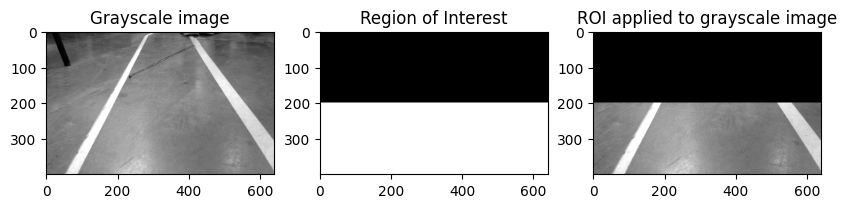

In [2]:
import numpy as np

mxHeight = 400
mxWidth = 640
roi_vertices = np.array([[
    [0, mxHeight - 1],
    [0, mxHeight >> 1],
    [mxWidth - 1, mxHeight >> 1],
    [mxWidth - 1, mxHeight - 1]    
]], dtype = np.int32) # Choosing the vertices of the region of interest

ignore_mask_color = 255
roi_mask = np.zeros((mxHeight, mxWidth), dtype = np.uint8)
roi = cv2.fillPoly(roi_mask, roi_vertices, ignore_mask_color)

img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # Convert image to grayscale
img_gray = cv2.resize(img_gray, (640, 400)) # Resize image to 640x400

plt.figure(figsize = (10, 15))
plt.subplot(131); plt.imshow(img_gray, cmap = 'gray'); plt.title('Grayscale image')
plt.subplot(132); plt.imshow(roi, cmap = 'gray'); plt.title('Region of Interest')
plt.subplot(133); plt.imshow(cv2.bitwise_and(img_gray, roi), cmap = 'gray'); plt.title('ROI applied to grayscale image')
plt.show()
img_gray = cv2.bitwise_and(img_gray, roi)

## Choose the threshold value for selecting lanes

From the gray scale image, we want to create an extremely 'black and white' image, meaning that each pixel is either 0 or 255. A pixel equals 255 means that it is likely to be part of the lane markings, otherwise it is zero.

If the intensity of a pixel is greater than a particular threshold, we can assign it to 255. The idea is that "the more white the better". If the pixel is white, is is very likely to be in the lane markings. To do this, we can use `cv2.inRange(lower_threshold, upper_threshold)`.

For now, let's choose lower_threshold = 160 or lower_threshold = 190

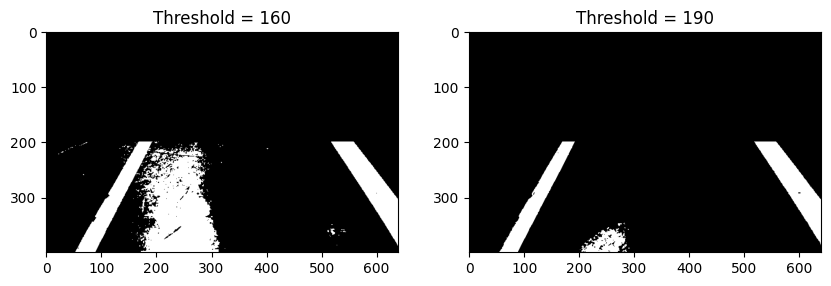

In [3]:
img_thresholded = cv2.inRange(img_gray, 160, 255) # Apply thresholding
plt.figure(figsize = (10, 15))
plt.subplot(121);plt.imshow(img_thresholded, cmap = 'gray'); plt.title('Threshold = 160')
img_thresholded = cv2.inRange(img_gray, 190, 255) # Apply thresholding
plt.subplot(122); plt.imshow(img_thresholded, cmap = 'gray'); plt.title('Threshold = 190')
plt.show()

As you may notice above, different threshold values has different effects on the image. The threshold value of 190 creates a new picture with less noise. However, it doesn't mean that the higher the threshold value, the better. A threshold value being too high may sabotage the lane detection. In addition, different light settings require different threshold values. Therefore, we should not hard-code the threshold value. Instead, we use a different approach to choose the threshold.

However, for now, let's stick with the threshold value = 160 first. We will come back later to this.

## Remove noise using erosion and dilation

As you may see in the above image, the noise looks like dots or thin lines on the image. To make the noise more managable, we use erosion and dilation. Erosion will delete small isolated noise in the image and dilation will bring back the original shape. We also observe that the noise after this process looks more "squared"

Text(0.5, 1.0, 'Filtered image')

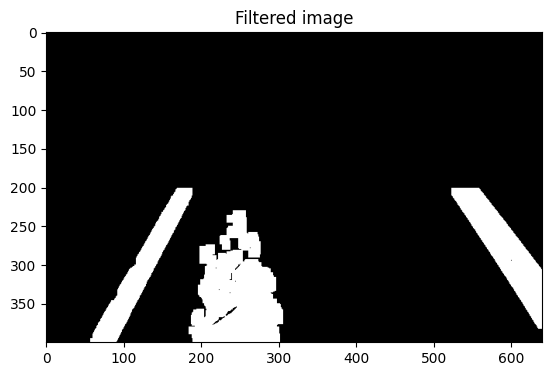

In [4]:
img_thresholded = cv2.inRange(img_gray, 160, 255)

def Filter(img, length=10):
    """Utility for filtering out noise."""
    res = img.copy()
    res = cv2.erode(res, np.ones((length, length), np.uint8))
    res = cv2.dilate(res, np.ones((length, length), np.uint8))
    return res

img_filtered = Filter(img_thresholded)
plt.imshow(img_filtered, cmap = 'gray')
plt.title('Filtered image')

## Detect edges using Canny Edge Detector and Hough Lines Transform

We use Canny Edge Detector to get the major edges of the image and then perform Hough Lines Transform on top of it. The threshold values we choose for Hough Lines Transform is pretty loose. The reason is because our main lane detector is the linear regressor. Choosing a tight threshold value will create too much loss of information

In [5]:
def draw_lines(img, lines, color = [255, 0, 0], thickness = 2):
    """Utility for drawing lines."""
    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

Text(0.5, 1.0, 'Detected Hough lines')

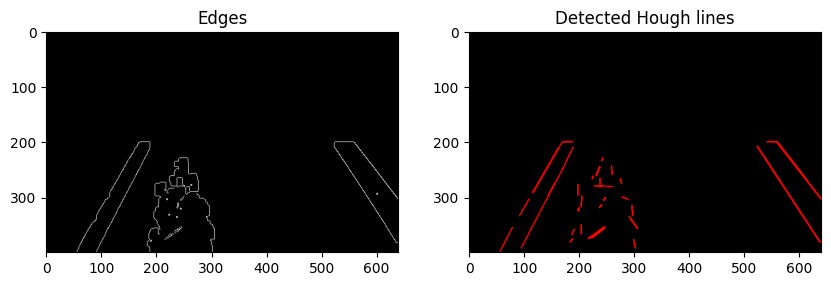

In [6]:
img_edges = cv2.Canny(img_filtered, 150, 220)

threshold = 20
min_line_len = 5
max_line_gap = 5

lines = cv2.HoughLinesP(
    img_edges, 1, np.pi / 180, threshold, 
    minLineLength = min_line_len, maxLineGap = max_line_gap)


hough = np.zeros((img_edges.shape[0], img_edges.shape[1], 3), dtype = np.uint8)
draw_lines(hough, lines)

plt.figure(figsize=(10, 15))
plt.subplot(121); plt.imshow(img_edges, cmap = 'gray'); plt.title('Edges')
plt.subplot(122); plt.imshow(hough); plt.title('Detected Hough lines')

## Choosing threshold values revisited

Earlier, we mentioned that we have our approach to choose the threshold value. Our condition that the threshold values will make the number of lines detected no more than 20 lines. The intuition is that having too much lines means we are having too much noise.

In [7]:
def getAdaptiveThreshold(img, roi, num_lines = 20):
    """Utility for getting adaptive threshold. Choose threshold that gives
    less amount of lines after Hough Transform"""
    for thresh in range(160, 230, 5):
        selected = Filter(cv2.inRange(img, thresh, 255))
        selected = cv2.bitwise_and(selected, roi)
        canny = cv2.Canny(selected, 150, 220)
        lines = cv2.HoughLinesP(canny, 1, 
                                np.pi / 180, 20, minLineLength = 5, 
                                maxLineGap = 5)
        if lines is not None and len(lines) <= num_lines:
            return thresh
    return 190 #Default value of threshold

print(getAdaptiveThreshold(img_gray, roi))

170


Voila! We should use the threshold value equals 170

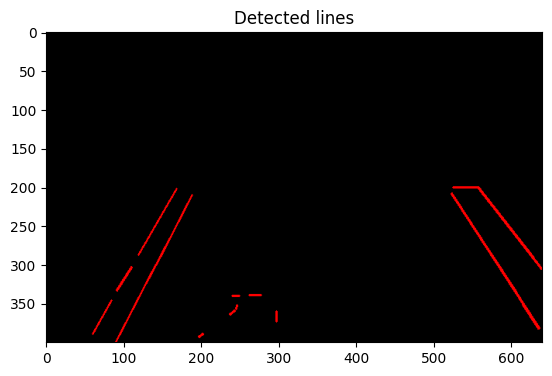

In [9]:
img_filtered = Filter(cv2.inRange(img_gray, 170, 255))
img_edges = cv2.Canny(img_filtered, 150, 220)

threshold = 20
min_line_len = 5
max_line_gap = 5

lines = cv2.HoughLinesP(
    img_edges, 1, np.pi / 180, threshold, 
    minLineLength = min_line_len, maxLineGap = max_line_gap)


hough = np.zeros((img_edges.shape[0], img_edges.shape[1], 3), dtype = np.uint8)
draw_lines(hough, lines)

plt.imshow(hough); plt.title('Detected lines')
plt.show()

In our code, we update the threshold value once every 10 frames.


## Using Linear Regression to detect the lanes

### Separating left lanes and right lanes

Every pixels with x-coordinate smaller or equals than width / 2 is considered to be on the left lane. The remainings are on the right lane

### Choice of sample

First, we need to choose the points to feed the linear regressor. Without loss of generality, let's consider the right lane first. The idea of choosing the samples is:

- For each row, we only want to get the first pixel that is equals 255 (to make sure that we can cover the outer-most lane marking)
- After getting those positions, we have to eliminate the outlier

In [16]:
# getting the first pixel that equals 255 for each row
x1 = []
y1 = []
for i in range(mxHeight >> 1, mxHeight - 20, 5):
    found = False
    for j in range(mxWidth - 1, mxWidth >> 1, -1):
        if (hough[i, j, 0] == 255):
            x1.append(i)
            y1.append(j)
            break

In case there is noise to the right of the lane markings, this approach would fail utterly in practice. Therefore, we have to eliminate values where the difference to the previous one is too high

In [17]:
y1 = np.array(y1)
x1 = np.array(x1)
diff = 40
lst = -1
for i in range(len(y1)):
    if (i > 0 and abs(lst - y1[i]) > diff): # If the gap is too high
        y1[i] = -1
        x1[i] = -1
    else:
        lst = y1[i]
mask = y1 != -1
y1 = y1[mask]
x1 = x1[mask]

If you looks carefully to the right lane, when the row index is high, what we would get is not the pixel of the outer lane-marking but actually the pixel of the inner lane-marking. To avoid that, we have to remove the inner pixels

In [18]:
# Find the first index where there is a gap between inner pixels and outer pixels
index = np.where(np.abs(np.diff(y1)) > 15)[0]

# If an index is found, remove all elements after that index
if index.size > 0 and index[0] >= (len(y1) >> 1):
    x1 = x1[:index[0]]
    y1 = y1[:index[0]]

### Applying Linear Regression

After selecting the samples, we can use `numpy.polyfit` to do the linear regression. The line returned by the `numpy.polyfit` function will fit the outer lane marking.

In [19]:
right_curve = np.poly1d(np.polyfit(x1,y1, 1))
print(right_curve)

 
0.7803 x + 403.1


As you can see, the line equation is y = 0.7803 x + 403.1

## Draw the lane

After getting the equation, we have to draw it on the image. 

In [20]:
def draw_fitted_line(img, fitted_line, color = [0, 255, 0], thickness = 2, grain=5):
    """Utility for drawing the line fitted to selected points."""
    mxHeight = img.shape[0]
    step = int((mxHeight - (mxHeight >> 1)) / grain)
    x = np.arange((mxHeight >> 1) - step, mxHeight, step)
    y = fitted_line(x)
    points = np.column_stack((y, x)).astype(np.int32)
    cv2.polylines(img, [points], False, color, thickness)

Text(0.5, 1.0, 'Right lane')

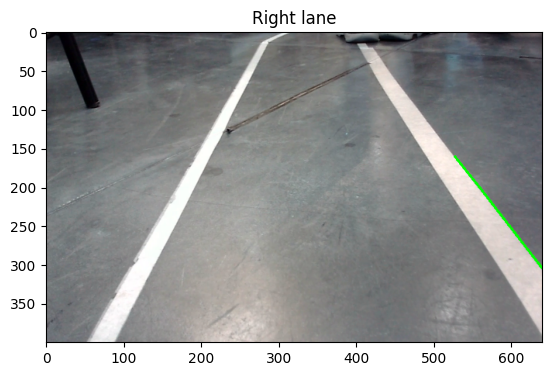

In [25]:
img = cv2.resize(img, (mxWidth, mxHeight))
draw_fitted_line(img, right_curve)
plt.imshow(img); plt.title('Right lane')

After getting the left lane and the right lane, the middle lane is obvious to compute: 

middle_curve = (right_curve + left_curve) / 2

Text(0.5, 1.0, 'Detected lane')

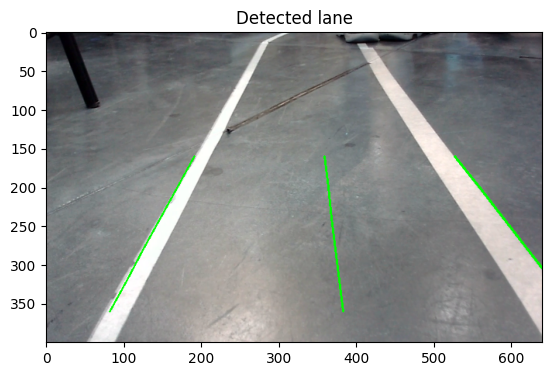

In [26]:
x1 = []
y1 = []
for i in range(mxHeight >> 1, mxHeight - 20, 5):
    for j in range(0, mxWidth >> 1, 1):
        if (hough[i, j, 0] == 255):
            x1.append(i)
            y1.append(j)
            break
y1 = np.array(y1)
x1 = np.array(x1)
diff = 40
lst = -1
for i in range(len(y1)):
    if (i > 0 and abs(lst - y1[i]) > diff):
        y1[i] = -1
        x1[i] = -1
    else:
        lst = y1[i]
mask = y1 != -1
y1 = y1[mask]
x1 = x1[mask]

# Find the first index where the condition is met
index = np.where(np.abs(np.diff(y1)) > 15)[0]

# If an index is found, remove all elements after that index
if index.size > 0 and index[0] >= (len(y1) >> 1):
    x1 = x1[:index[0]]
    y1 = y1[:index[0]]
left_curve  = np.poly1d(np.polyfit(x1,y1, 1))
middle_curve = (left_curve + right_curve) / 2
draw_fitted_line(img, left_curve)
draw_fitted_line(img, middle_curve)

plt.imshow(img); plt.title('Detected lane')

### Distance to the middle lane

First, we draw a horizontal line at y = 300

Then, the distane to the middle lane is the real distance between pixel (mxWidth / 2, 300) and (middle_curve(300), 300)


Text(0.5, 1.0, 'Detected lane')

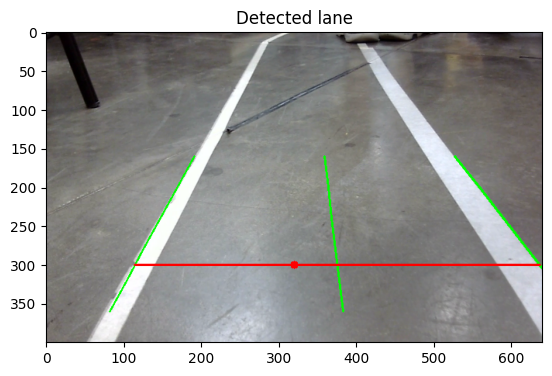

In [29]:
horizontal = 300
    
cv2.line(img, (int(left_curve(horizontal)), horizontal), 
            (int(right_curve(horizontal)), horizontal), (0, 0, 255), 2)

cv2.circle(img, (mxWidth >> 1, 300), 5, (0, 0, 255), -1)

plt.imshow(img[:,:,::-1]); plt.title('Detected lane')

To find that real distance, we use the fact that the Z values (or the depth) of the two points in real life are equal. The real x and y value of the pixels can be found using this formula.

Let:
- $d=$ distance from the camera to the object
- $\text{objmm} = $ the size of the object in real life in milimeter (mm)
- $\text{objsensor} =$ the size of the object's image in the sensor in milimeter (mm)
- $\text{objpixel} =$ the size of the object's image in the sensor in pixels
- $F=$ Focal length
- $f_x$ is the first parameter we get from the Intrinsic Camera matrix in the unit of pixel

$$\text{objmm} = \frac{\text{objsensor} * d}{F} = \frac{\text{objpixel} * F * d}{F* f_x} = \frac{\text{objpixel} * d}{f_x}$$

In [30]:
import yaml
from yaml.loader import SafeLoader
with open('cam.yaml') as f:
    data = yaml.load(f, Loader=SafeLoader)

coeff = 1 / (data['camera_matrix'][0][0])
distance_to_hori_line = 150 #distance to the horizontal line in cm

dist = ((right_curve + left_curve) / 2)(horizontal) - (mxWidth >> 1) #distance to the middle line in pixels
dist = round(dist * coeff * distance_to_hori_line, 3) #distance to the middle line in cm

dist

5.912

Please note that the distance_to_hori_line is measured according to the installation of "sample6.mp4". If you want to check the features, please run with sample6.mp4

### Evaluation

Plese have a look at the file ./eval/summary.xlsx 

Each row corresponds to one measurement attempt. The corresponding image can be found in ./eval/measurements folder


## Find lane width

To find lane width, we also use the same method to calculate the real distance. Please find the evaluation in the previous folder

In [32]:
distance_to_hori_line = 150 #distance to the horizontal line in cm
lane_width = (right_curve(horizontal) - left_curve(horizontal)) * coeff * distance_to_hori_line
lane_width = round(lane_width, 3)
lane_width

55.035

Please note that the number is not correct because this image doesn't have the same setting as the images in sample6.mp4